# The forward and backward passes

In [ ]:
import math, os, time, shutil, torch, matplotlib as mpl, numpy as np
import matplotlib.pyplot as plt

from torch import tensor
from torch import nn
import torch.nn.functional as F
from fastcore.test import test_close
torch.manual_seed(42)

mpl.rcParams['image.cmap'] = 'gray'
torch.set_printoptions(precision=2, linewidth=125, sci_mode=False)
np.set_printoptions(precision=2, linewidth=125)

In [ ]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# Define transform to convert images to tensors and flatten them
transform = transforms.Compose([
    transforms.ToTensor(), # Convert to tensor and normalize to [0, 1]
    transforms.Lambda(lambda x: x.view(-1)) # Flatten to 784 pixels
])

# Load MNIST dataset
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Extract data and labels as tensors
x_train, y_train = zip(*mnist_train)
x_valid, y_valid = zip(*mnist_test)

# Convert to tensors
x_train = torch.stack(x_train) # Combines images into a single tensor.
y_train = torch.tensor(y_train)
x_valid = torch.stack(x_valid)
y_valid = torch.tensor(y_valid)

# Fundations Version

## Basic architecture

In [ ]:
n, m = x_train.shape
c = y_train.max()+1
print(f"Training samples: {n}\nNumber of pixels: {m}\nNumber of possible outcome: {c}")

Training samples: 60000
Number of pixels: 784
Number of possible outcome: 10


In [ ]:
# num hidden
nh = 50

In [ ]:
w1 = torch.randn(m, nh)
b1 = torch.zeros(nh)
w2 = torch.randn(nh, 1) # We are leaving at one output because we will be using MSE for now, this me we will just output what number we think it is from 0 - 10. This is only for simplicity.
b2 = torch.zeros(1)

In [ ]:
# linear layer
def lin(x, w, b):
  return x@w + b

In [ ]:
t = lin(x_valid, w1, b1)
t.shape

torch.Size([10000, 50])

In [ ]:
def relu(x):
  return x.clamp_min(0.)

In [ ]:
t = relu(t)
t

tensor([[ 9.29,  2.50,  0.00,  ...,  0.00,  2.37, 13.58],
        [ 0.00,  0.00,  0.00,  ...,  0.00,  0.00,  6.45],
        [ 0.00,  3.45,  0.00,  ...,  6.08,  4.49,  4.17],
        ...,
        [ 5.17, 12.24,  0.00,  ..., 14.33,  1.39, 25.14],
        [ 5.17,  4.77, 10.26,  ...,  8.97,  6.15, 15.86],
        [ 2.73,  0.00,  9.40,  ..., 10.27,  0.00, 21.07]])

In [ ]:
# creating MLP from scratch
def model(xb):
  l1 = lin(xb, w1, b1)
  l2 = relu(l1)
  return lin(l2, w2, b2)

In [ ]:
res = model(x_valid)
res.shape

torch.Size([10000, 1])

## Loss function: MSE

(`mse` is not a suitable loss function for multi-class classification; We'll use `mse` for now to keep things simple.)

In [ ]:
res.shape, y_valid.shape

(torch.Size([10000, 1]), torch.Size([10000]))

In [ ]:
# Broadcasting

# We can either remove the column or we add a column

(res.squeeze() - y_valid).shape

torch.Size([10000])

In [ ]:
y_train, y_valid = y_train.long(), y_valid.long()

preds = model(x_train)
preds.shape

torch.Size([60000, 1])

In [ ]:
def mse(output, target):
  return ((output[:,0] - target)**2).mean()

In [ ]:
mse(preds, y_train)

tensor(4314.73)

## Gradient and backward pass

In [ ]:
from sympy import symbols, diff
x, y = symbols('x y')
diff(x**2, x)

2*x

In [ ]:
diff(3*x**2+9, x)

6*x

In [ ]:
def lin_grad(inp, out, w, b):
  # grad of matmul with respect to input
  inp.g = out.g @ w.t() # gradient w.r.t input. Output: [n, in_features]
  w.g = inp.t()@out.g # gradient for weights. Output: [in_features, out_features]
  b.g = out.g.sum(0) # gradient for bias. Output: [out_features]

The function calculates gradients of the loss with respect to `inp`, `w`, and `b` using the chain rule, given the gradient of the loss with respect to `out` (storted as `out.g`).

In [ ]:
def forward_and_backward(inp, targ):
  # forward pass:
  l1 = lin(inp, w1, b1)
  l2 = relu(l1)
  out = lin(l2, w2, b2)
  diff = out[:,0]-targ # Extracts the first column of out([n]), subtracts targ([n]), resulting in [n]
  loss = diff.pow(2).mean() # Compute MSE

  # Backward pass: compures gradients of the loss w.r.t. all parameters (w1, b1, w2, b2) and inputs (inp, l1, l2) using the chain rule.
  out.g = 2.*diff[:, None]/ inp.shape[0] # Gradient of loss w.r.t output. diff[:, None] adds a dimension for broadcasting, matching out's shape
  # Propagates gradients backward through the second linear layer, ReLU, and first linear layer using the chain rule
  lin_grad(l2, out, w2, b2)
  l1.g = (l1>0).float() * l2.g
  lin_grad(inp, l1, w1, b1)

In [ ]:
forward_and_backward(x_train, y_train)

In [ ]:
def get_grad(x): return x.g.clone()
chks = w1,w2,b1,b2,x_train
grads = w1g,w2g,b1g,b2g,ig = tuple(map(get_grad, chks))

In [ ]:
def mkgrad(x): return x.clone().requires_grad_(True)
ptgrads = w12,w22,b12,b22,xt2 = tuple(map(mkgrad, chks))

In [ ]:
def forward(inp, targ):
  l1 = lin(inp, w12, b12)
  l2 = relu(l1)
  out = lin(l2, w22, b22)
  return mse(out, targ)

In [ ]:
loss = forward(xt2, y_train)
loss.backward()

In [ ]:
for a, b in zip(grads, ptgrads):
  test_close(a, b.grad, eps=0.01)

# Refactor model

## Layers as classes

In [ ]:
class Relu():
  def __call__(self, inp):
    self.inp = inp
    self.out = inp.clamp_min(0.)
    return self.out

  def backward(self):
    self.inp.g = (self.inp>0).float() * self.out.g

In [ ]:
class Lin():
  def __init__(self, w, b):
    self.w = w
    self.b = b

  def __call__(self, inp):
    self.inp = inp
    self.out = lin(inp, self.w, self.b)
    return self.out

  def backward(self):
    self.inp.g = self.out.g @ self.w.t()
    self.w.g = self.inp.t() @ self.out.g
    self.b.g = self.out.g.sum(0)

In [ ]:
class Mse():
  def __call__(self, inp, targ):
    self.inp = inp
    self.targ = targ
    self.out = mse(inp, targ)
    return self.out

  def backward(self):
    self.inp.g = 2. * (self.inp.squeeze() - self.targ).unsqueeze(-1) / self.targ.shape[0]

In [ ]:
class Model():
  def __init__(self, w1, b1, w2, b2):
    self.layers = [Lin(w1, b1), Relu(), Lin(w2, b2)]
    self.loss = Mse()

  def __call__(self, x, targ):
    for l in self.layers:
      x = l(x)
    return self.loss(x, targ)

  def backward(self):
    self.loss.backward()
    for l in reversed(self.layers):
      l.backward()

In [ ]:
model = Model(w1, b1, w2, b2)

In [ ]:
loss = model(x_train, y_train)

In [ ]:
model.backward()

In [ ]:
test_close(w2g, w2.g, eps=0.01)
test_close(b2g, b2.g, eps=0.01)
test_close(w1g, w1.g, eps=0.01)
test_close(b1g, b1.g, eps=0.01)
test_close(ig, x_train.g, eps=0.01)

## Module.forward()

In [ ]:
class Module():
  def __call__(self, *args):
    self.args = args
    self.out = self.forward(*args)
    return self.out

  def forward(self):
    raise Exception('not implemented')
  def backward(self):
    self.bwd(self.out, *self.args)
  def bwd(self):
    raise Exception('not implemented')

In [ ]:
class Relu(Module):
  def forward(self, inp):
    return inp.clamp_min(0.)
  def bwd(self, out, inp):
    inp.g = (inp>0).float() * out.g

In [ ]:
class Lin(Module):
  def __init__(self, w, b):
    self.w = w
    self.b = b
  def forward(self, inp):
    return inp @ self.w + self.b
  def bwd(self, out, inp):
    inp.g = self.out.g @ self.w.t()
    self.w.g = inp.t() @ self.out.g
    self.b.g = self.out.g.sum(0)

In [ ]:
class Mse(Module):
  def forward (self, inp, targ):
    return (inp.squeeze() - targ).pow(2).mean()
  def bwd(self, out, inp, targ):
    inp.g = 2 *(inp.squeeze()-targ).unsqueeze(-1) / targ.shape[0]

In [ ]:
model = Model(w1, b1, w2, b2)

In [ ]:
loss = model(x_train, y_train)

In [ ]:
model.backward()

In [ ]:
test_close(w2g, w2.g, eps=0.01)
test_close(b2g, b2.g, eps=0.01)
test_close(w1g, w1.g, eps=0.01)
test_close(b1g, b1.g, eps=0.01)
test_close(ig, x_train.g, eps=0.01)

## Autograd

In [ ]:
class Linear(nn.Module):
  def __init__(self, n_in, n_out):
    super().__init__()
    self.w = torch.randn(n_in, n_out).requires_grad_()
    self.b = torch.zeros(n_out).requires_grad_()
  def forward(self, inp):
    return inp@self.w + self.b

In [ ]:
class Model(nn.Module):
  def __init__(self, n_in, nh, n_out):
    super().__init__()
    self.layers = [Linear(n_in, nh), nn.ReLU(), Linear(nh, n_out)]

  def __call__(self, x, targ):
    for l in self.layers:
      x = l(x)
    return F.mse_loss(x, targ[:,None])

In [ ]:
model = Model(m, nh, 1)
loss = model(x_train, y_train)
loss.backward()

In [ ]:
l0 = model.layers[0]
l0.b.grad

tensor([-19.69,  -2.37,  -0.11,   1.99,  12.68, -15.26, -18.45,   0.34,   3.74,  14.70,  10.83,  12.20,  -2.92, -28.14,
          0.76,  69.35, -22.03,  49.92,  -7.11,   1.41,  25.15,  11.33, -17.96, -13.17, -17.67, -10.45,  -0.10, -18.96,
        -34.67,  -0.82,  40.97,   4.43,  62.47,  31.72,  55.54,  45.16,   3.19,  12.82,  12.32,  -1.42,   4.51,  -6.06,
        -62.45,  -1.84,  -1.40,   7.05,   0.47,  18.77,  -4.73,  -6.43])

# Minibatch_training

In [ ]:
n, m = x_train.shape
c = y_train.max()+1
nh = 50

In [ ]:
class Model(nn.Module):
  def __init__(self, n_in, nh, n_out):
    super().__init__()
    self.layers = [nn.Linear(n_in, nh), nn.ReLU(), nn.Linear(nh, n_out)]

  def __call__(self, x):
    for l in self.layers:
      x = l(x)
    return x

In [ ]:
model = Model(m, nh, 10)
pred = model(x_train)
pred.shape

torch.Size([60000, 10])

## Cross entropy loss

First, we will need to compute the softmax of our activations. This is defined by:

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{e^{x_{0}} + e^{x_{1}} + \cdots + e^{x_{n-1}}}$$

or more concisely:

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{\sum\limits_{0 \leq j \lt n} e^{x_{j}}}$$

In practice, we will need the log of the softmax when we calculate the loss.

In [ ]:
# def log_softmax(x):
#   return (x.exp()/(x.exp().sum(-1, keepdim=True))).log()

In [ ]:
# simplification when we compute the log softmax:
# def log_softmax(x): return x - x.exp().sum(-1,keepdim=True).log()

Then, there is a way to compute the log of the sum of exponentials in a more stable way, called the [LogSumExp trick](https://en.wikipedia.org/wiki/LogSumExp). The idea is to use the following formula:

$$\log \left ( \sum_{j=1}^{n} e^{x_{j}} \right ) = \log \left ( e^{a} \sum_{j=1}^{n} e^{x_{j}-a} \right ) = a + \log \left ( \sum_{j=1}^{n} e^{x_{j}-a} \right )$$

where a is the maximum of the $x_{j}$.

In [ ]:
def logsumexp(x):
    m = x.max(-1)[0]
    return m + (x-m[:,None]).exp().sum(-1).log()

In [ ]:
# This way, we will avoid an overflow when taking the exponential of a big activation. In PyTorch, this is already implemented for us.

def log_softmax(x): return x - x.logsumexp(-1,keepdim=True)

In [ ]:
test_close(logsumexp(pred), pred.logsumexp(-1))
sm_pred = log_softmax(pred)
sm_pred

tensor([[-2.36, -2.28, -2.09,  ..., -2.43, -2.47, -2.11],
        [-2.37, -2.25, -2.09,  ..., -2.46, -2.43, -2.11],
        [-2.34, -2.32, -2.14,  ..., -2.44, -2.48, -2.14],
        ...,
        [-2.34, -2.28, -2.17,  ..., -2.38, -2.43, -2.14],
        [-2.36, -2.33, -2.18,  ..., -2.43, -2.37, -2.20],
        [-2.38, -2.28, -2.22,  ..., -2.43, -2.41, -2.19]], grad_fn=<SubBackward0>)

The cross entropy loss ofr some target $x$ and some prediction $p(x)$ is given by:

$$ -\sum x\, \log p(x) $$

But since our $x$s are 1-hot encoded (actually, they're just the integer indices), this can be rewritten as $-\log(p_{i})$ where i is the index of the desired target.

In [ ]:
y_train[:3]

tensor([5, 0, 4])

In [ ]:
sm_pred[0,5],sm_pred[1,0],sm_pred[2,4]

(tensor(-2.40, grad_fn=<SelectBackward0>),
 tensor(-2.37, grad_fn=<SelectBackward0>),
 tensor(-2.14, grad_fn=<SelectBackward0>))

In [ ]:
sm_pred[[0, 1, 2], y_train[:3]]

tensor([-2.40, -2.37, -2.14], grad_fn=<IndexBackward0>)

The cross entropy loss for some target $x$ and some prediction $p(x)$ is given by:

$$ -\sum x\, \log p(x) $$

But since our $x$s are 1-hot encoded (actually, they're just the integer indices), this can be rewritten as $-\log(p_{i})$ where i is the index of the desired target.

In [ ]:
def nll(input, target):
  return -input[range(target.shape[0]), target].mean()

In [ ]:
loss = nll(sm_pred, y_train)
loss

tensor(2.30, grad_fn=<NegBackward0>)

Then use PyTorch's implementation. `negative likelihood loss`

In [ ]:
test_close(F.nll_loss(F.log_softmax(pred, -1), y_train), loss, 1e-3)

In PyTorch, `F.log_softmax` and `F.nll_loss` are combined in one optimized function, `F.cross_entropy`.

In [ ]:
test_close(F.cross_entropy(pred, y_train), loss, 1e-3)

## Basic training loop

Basically the training loop repeats over the following steps:


*   get the output of the model on a batch of inputs
*   compare the output to the labels we have and compute a loss
*  calculate the gradients of the loss with respect to every paremeter of the model
*  update said parameters with those gradients to make them a little bit better



In [ ]:
loss_func = F.cross_entropy

In [ ]:
bs = 50             # batch size


xb = x_train[0:bs]  # a mini-batch from x
preds = model(xb)   # predictions
preds[0], preds.shape

(tensor([-0.05,  0.03,  0.22,  0.02,  0.00, -0.09, -0.04, -0.12, -0.16,  0.20], grad_fn=<SelectBackward0>),
 torch.Size([50, 10]))

In [ ]:
yb = y_train[0:bs]
yb

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1, 1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7,
        6, 1, 8, 7, 9, 3, 9, 8, 5, 9, 3])

In [ ]:
loss_func(preds, yb)

tensor(2.28, grad_fn=<NllLossBackward0>)

In [ ]:
preds.argmax(dim=1)

tensor([2, 2, 4, 2, 2, 9, 2, 2, 1, 9, 9, 9, 2, 2, 1, 2, 2, 2, 9, 9, 2, 2, 9, 2, 2, 2, 2, 2, 2, 1, 9, 1, 2, 2, 2, 9, 2, 9, 2,
        9, 9, 2, 9, 2, 9, 2, 2, 2, 2, 2])

In [ ]:
def accuracy(out, yb):
  return (out.argmax(dim=1)==yb).float().mean()

In [ ]:
accuracy(preds, yb)

tensor(0.16)

In [ ]:
lr = 0.5
epochs = 3

In [ ]:
def report(loss, preds, yb):
  print(f'{loss:.2f}, {accuracy(preds, yb):.2f}')

In [ ]:
xb, yb = x_train[:bs], y_train[:bs]
preds = model(xb)
report(loss_func(preds, yb), preds, yb)

2.28, 0.16


In [ ]:
for epoch in range(epochs):
  for i in range(0, n, bs):
    s = slice(i, min(n, i+bs))
    xb, yb = x_train[s], y_train[s]
    preds = model(xb)
    loss = loss_func(preds, yb)
    loss.backward()
    with torch.no_grad():
      for l in model.layers:
        if hasattr(l, 'weight'):
          l.weight -= l.weight.grad * lr
          l.bias   -= l.bias.grad   * lr
          l.weight.grad.zero_()
          l.bias.grad.zero_()
  report(loss, preds, yb)

0.04, 1.00
0.02, 1.00
0.01, 1.00


Here's a list of everything we did in this notebook:

- Loaded the MNIST dataset and prepared the data for training.
- Built a simple two-layer neural network (MLP) from scratch using basic PyTorch operations.
- Implemented the forward and backward passes manually for the MLP.
- Compared the manually calculated gradients with PyTorch's autograd to verify correctness.
- Refactored the model by creating classes for layers (`Relu`, `Lin`, `Mse`, and `Model`) to make the code more modular and object-oriented.
- Further refactored the layer classes to inherit from a base `Module` class, mimicking PyTorch's `nn.Module`.
- Replaced the custom layers with PyTorch's built-in `nn.Linear` and `nn.ReLU` to leverage autograd.
- Switched from Mean Squared Error (MSE) loss to Cross-Entropy loss, which is more suitable for multi-class classification problems like MNIST.
- Implemented and tested the `log_softmax` and `logsumexp` functions, and compared them with PyTorch's implementations.
- Introduced the concept of negative likelihood loss (`nll`) and verified it against PyTorch's `F.nll_loss` and `F.cross_entropy`.
- Set up a basic training loop with mini-batches.
- Implemented an accuracy metric to evaluate the model's performance.
- Performed a basic training run using the implemented training loop, loss function, and optimizer (manual gradient updates).

## Using parameters and optim

## Parameters

In [ ]:
class MLP(nn.Module):
  def __init__(self, n_in, nh, n_out):
    super().__init__()
    self.l1 = nn.Linear(n_in, nh)
    self.l2 = nn.Linear(nh, n_out)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.l2(self.relu(self.l1(x)))

In [ ]:
model = MLP(m, nh, 10)
model.l1

Linear(in_features=784, out_features=50, bias=True)

In [ ]:
model

MLP(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
  (relu): ReLU()
)

In [ ]:
for name, l in model.named_children():
  print(f'{name}: {l}')

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)
relu: ReLU()


In [ ]:
for p in model.parameters():
  print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


In [ ]:
def fit():
  for epoch in range(epochs):
    for i in range(0, n, bs):
      s = slice(i, min(n, i+bs))
      xb, yb = x_train[s], y_train[s]
      preds = model(xb)
      loss = loss_func(preds, yb)
      loss.backward()
      with torch.no_grad():
        for p in model.parameters():
          p -= p.grad * lr
        model.zero_grad()
    report(loss, preds, yb)

In [ ]:
fit()

0.09, 0.96
0.04, 1.00
0.03, 1.00


How does it automatically determine the layers and parameters?

**Let's break it down.**

Behind the scenes. PyTorch overides the `__setattr__` function in `nn.Module` so that the submodules we define are properly registered as parameters of the model.

In [ ]:
class MyModule():
  def __init__(self, n_in, nh, n_out):
    self._modules = {}
    self.l1 = nn.Linear(n_in, nh)
    self.l2 = nn.Linear(nh, n_out)

  def __setattr__(self, k, v):
    if not k.startswith("_"):
      self._modules[k] = v
    super().__setattr__(k, v)

  def __repr__(self):
    return f'{self._modules}'

  def parameters(self):
    for l in self._modules.values():
      yield from l.parameters()

In [ ]:
mdl = MyModule(m, nh, 10)
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [ ]:
for p in mdl.parameters():
  print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


### Registering modules

In [ ]:
from functools import reduce

In [ ]:
layers = [nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10)]

NameError: name 'nn' is not defined

In [ ]:
class Model(nn.Module):
  def __init__(self, layers):
    super().__init__()
    self.layers = layers
    for i, l in enumerate(self.layers):
      self.add_module(f'layer_{i}', l)

  def forward(self, x):
    return reduce(lambda val, layer: layer(val), self.layers, x)

In [ ]:
model = Model(layers)
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

**nn.ModuleList**

`nn.Modulelist` does this for us.

In [ ]:
class SequentialModel(nn.Module):
  def __init__(self, layers):
    super(). __init__()
    self.layers = nn.ModuleList(layers)

  def forward(self, x):
    for l in self.layers:
      x = l(x)
    return x

In [ ]:
model = SequentialModel(layers)
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [ ]:
fit()

0.12, 0.96
0.07, 0.96
0.02, 1.00


### nn.Sequential

`nn.Sequential` is a convenient class which does the same as the above.

In [ ]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))

In [ ]:
fit()

0.07, 0.96
0.01, 1.00
0.01, 1.00


### Optim

In [ ]:
class Optimizer():
  def __init__(self, params, lr=0.5):
    self.params = list(params)
    self.lr = lr

  def step(self):
    with torch.no_grad():
      for p in self.params:
        p -= p.grad * self.lr

  def zero_grad(self):
    for p in self.params:
      p.grad.data.zero_()

In [ ]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))

In [ ]:
opt = Optimizer(model.parameters())

In [ ]:
for epoch in range(epochs):
  for i in range(0, n, bs):
    s = slice(i, min(n, i+bs))
    xb, yb = x_train[s], y_train[s]
    preds = model(xb)
    loss = loss_func(preds, yb)
    loss.backward()
    opt.step()
    opt.zero_grad()
  report(loss, preds, yb)

0.13, 0.96
0.02, 1.00
0.01, 1.00


Pytorch already provides this exact functionality in `optim.SGD` (it also handles stuff like momentum)

In [ ]:
from torch import optim

In [ ]:
def get_model():
  model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))
  return model, optim.SGD(model.parameters(), lr=lr)

In [ ]:
model, opt = get_model()
loss_func(model(xb), yb)

tensor(2.32, grad_fn=<NllLossBackward0>)

In [ ]:
for epoch in range(epochs):
  for i in range (0, n, bs):
    s = slice(i, min(n, i+bs))
    xb, yb = x_train[s], y_train[s]
    preds = model(xb)
    loss = loss_func(preds, yb)
    loss.backward()
    opt.step()
    opt.zero_grad()
  report(loss, preds, yb)

0.03, 1.00
0.06, 0.96
0.02, 1.00


## Dataset and DataLoader

### Dataset

it's clunky to iterate through minibatches of x and y values separately. Instead let's do these two steps together by introducing a `Dataset` class:

In [ ]:
class Dataset():
  def __init__(self, x, y):
    self.x = x
    self.y = y
  def __len__(self):
    return len(self.x)
  def __getitem__(self, i):
    return self.x[i], self.y[i]

In [ ]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
assert len(train_ds) == len(x_train)
assert len(valid_ds) == len(y_valid)

In [ ]:
xb, yb = train_ds[0:5]
assert xb.shape == (5, 28 * 28)
assert yb.shape == (5,)
xb, yb

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([5, 0, 4, 1, 9]))

In [ ]:
model, opt = get_model()

In [ ]:
for epoch in range(epochs):
  for i in range(0, n, bs):
    xb, yb = train_ds[i: min(n,i+bs)]
    preds = model(xb)
    loss = loss_func(preds, yb)
    loss.backward()
    opt.step()
    opt.zero_grad()
  report(loss, preds, yb)

0.05, 1.00
0.02, 1.00
0.01, 1.00


### DataLoader

Now let's replace this two line of code:

```python
for i in range(0, n, bs):
  xb, yb = train_ds[i, min(n, i+bs)]
  ...
```

with:
```python
for xb, yb in train_dl:
  ...
```

In [ ]:
class DataLoader():
  def __init__(self, ds, bs):
    self.ds = ds
    self.bs = bs
  def __iter__(self):
    for i in range(0, len(self.ds), self.bs):
      yield self.ds[i: i+self.bs]

In [ ]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

In [ ]:
xb, yb = next(iter(valid_dl))

In [ ]:
xb.shape

torch.Size([50, 784])

In [ ]:
yb

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2,
        1, 1, 7, 4, 2, 3, 5, 1, 2, 4, 4])

tensor(7)

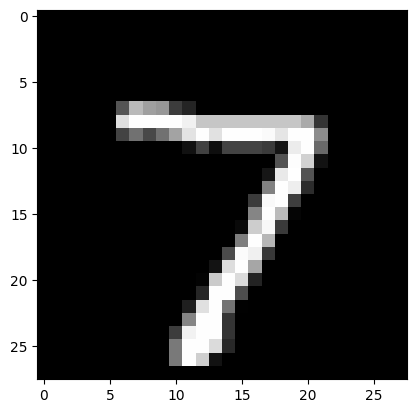

In [ ]:
plt.imshow(xb[0].view(28,28))
yb[0]

In [ ]:
model, opt = get_model()

In [ ]:
def fit():
  for epoch in range(epochs):
    for xb, yb in train_dl:
      pred = model(xb)
      loss = loss_func(pred, yb)
      loss.backward()
      opt.step()
      opt.zero_grad()
    report(loss, pred, yb)

In [ ]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

0.07, 0.96
0.02, 1.00
0.03, 0.98


(tensor(0.04, grad_fn=<NllLossBackward0>), tensor(0.98))

### Random sampling

We want our training set to be in a random order, and that order should differ each iteretion. But the validation shouldn't be randomized.

In [ ]:
import random

In [ ]:
class Sampler():
  def __init__(self, ds, shuffle=False):
    self.n = len(ds)
    self.shuffle = shuffle
  def __iter__(self):
    res = list(range(self.n))
    if self.shuffle:
      random.shuffle(res)
    return iter(res)

In [ ]:
from itertools import islice

In [ ]:
ss = Sampler(train_ds)

In [ ]:
it = iter(ss)
for o in range(5):
  print(next(it))

0
1
2
3
4


In [ ]:
list(islice(it, 5))

[5, 6, 7, 8, 9]

In [ ]:
ss = Sampler(train_ds, shuffle=True)
list(islice(ss, 5))

[10150, 2106, 23095, 33440, 10895]

Then we can use this to create a batch sampler

In [ ]:
import fastcore.all as fc

In [ ]:
class BatchSampler():
  def __init__(self, sampler, bs, drop_last=False):
    # sampler, bs, drop_last = self.sampler, self.bs, self.drop_last
    fc.store_attr()
  def __iter__(self):
    yield from fc.chunked(iter(self.sampler), self.bs, drop_last=self.drop_last)

In [ ]:
batchs = BatchSampler(ss, 5)
list(islice(batchs, 6))

[[55708, 29060, 33261, 10000, 34969],
 [1566, 37503, 37817, 9023, 52377],
 [45649, 39701, 8253, 32753, 45098],
 [24732, 4693, 41939, 10793, 33664],
 [51267, 44280, 45696, 25214, 26457],
 [51215, 40490, 50453, 29359, 31126]]

In [ ]:
def collate(b):
  xs, ys = zip(*b)
  return torch.stack(xs), torch.stack(ys)

In [ ]:
class DataLoader():
  def __init__(self, ds, batchs, collate_fn=collate):
    fc.store_attr()
  def __iter__(self):
    yield from (self.collate_fn(self.ds[i] for i in b) for b in self.batchs)

In [ ]:
# o = next(iter(train_samp))
# p = [train_ds[i] for i in o]
# xs, ys = zip(*p)
# torch.stack(xs)

In [ ]:
train_samp = BatchSampler(Sampler(train_ds, shuffle=True), bs)
valid_samp = BatchSampler(Sampler(valid_ds, shuffle=False), bs)

In [ ]:
train_dl = DataLoader(train_ds, train_samp)
valid_dl = DataLoader(valid_ds, valid_samp)

tensor(3)

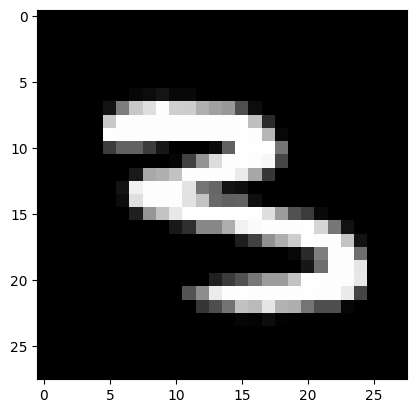

In [ ]:
xb,yb = next(iter(train_dl))
plt.imshow(xb[0].view(28, 28))
yb[0]

## Multiprocessing DataLoader

Multiprocessing just like in pytorch means that
``` python
self.ds[i]
```
It can be run in parallel for multiple items. So that code can be opening a jpeg, rotating and flipping it

In [ ]:
import torch.multiprocessing as mp
from fastcore.basics import store_attr

In [ ]:
train_ds[[3, 6, 8, 1]]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([1, 1, 1, 0]))

In [ ]:
train_ds.__getitem__([3, 6, 8, 1])

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([1, 1, 1, 0]))

In [ ]:
for o in map(train_ds.__getitem__, ([3, 6], [8, 1])):
  print(o)

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([1, 1]))
(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([1, 0]))


In [ ]:
class DataLoader():
  def __init__(self, ds, batchs, n_workers=1, collate_fn=collate):
    fc.store_attr()
  def __iter__(self):
    with mp.Pool(self.n_workers) as ex:
      yield from ex.map(self.ds.__getitem__, iter(self.batchs))

In [ ]:
train_dl = DataLoader(train_ds, batchs=train_samp, n_workers=2)
it = iter(train_dl)

In [ ]:
xb,yb = next(it)
xb.shape, yb.shape

(torch.Size([50, 784]), torch.Size([50]))

# PyTorch DataLoader

In [ ]:
from torch.utils. data import DataLoader, SequentialSampler, RandomSampler

In [ ]:
train_samp = BatchSampler(RandomSampler(train_ds), bs)
valid_samp = BatchSampler(SequentialSampler(valid_ds), bs)

In [ ]:
train_dl = DataLoader(train_ds, batch_sampler=train_samp, collate_fn=collate)
valid_dl = DataLoader(valid_ds, batch_sampler=valid_samp, collate_fn=collate)

In [ ]:
model, opt = get_model()
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

0.07, 0.98
0.11, 0.96
0.01, 1.00


(tensor(0.04, grad_fn=<NllLossBackward0>), tensor(1.))

Pytorch can auto-generate the Batchsampler for us instead of manually using the batchsampler repeatedly.

In [ ]:
train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds), collate_fn=collate)
valid_dl = DataLoader(valid_ds, bs, sampler=SequentialSampler(valid_ds), collate_fn=collate)

In [ ]:
train_dl = DataLoader(train_ds, bs, shuffle=True, drop_last=True, num_workers=2)
valid_dl = DataLoader(valid_ds, bs, shuffle=False, num_workers=2)

In [ ]:
model, opt = get_model()
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

0.19, 0.94
0.10, 0.94
0.04, 1.00


(tensor(0.21, grad_fn=<NllLossBackward0>), tensor(0.94))

In [ ]:
train_dl = DataLoader(train_ds, sampler=train_samp)
valid_dl = DataLoader(valid_ds, sampler=valid_samp)

In [ ]:
xb, yb = next(iter(train_dl))
xb.shape, yb.shape

(torch.Size([1, 50, 784]), torch.Size([1, 50]))

## Validation

Use validation set to identify when you are overfitting.



In [ ]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb,yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

        model.eval()
        with torch.no_grad():
            tot_loss,tot_acc,count = 0.,0.,0
            for xb,yb in valid_dl:
                pred = model(xb)
                n = len(xb)
                count += n
                tot_loss += loss_func(pred,yb).item()*n
                tot_acc  += accuracy (pred,yb).item()*n
        print(epoch, tot_loss/count, tot_acc/count)
    return tot_loss/count, tot_acc/count

In [ ]:
def get_dls(train_ds, valid_ds, bs, **kwargs):
  return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
          DataLoader(valid_ds, batch_size=bs*2, **kwargs))

In [ ]:
train_dl, valid_dl = get_dls(train_ds, valid_ds, bs)
model, opt = get_model()
loss, acc = fit(5, model, loss_func, opt, train_dl, valid_dl)

0 0.13149705038871617 0.9585000079870224
1 0.11669149911729619 0.964200005531311
2 0.10573875582311303 0.9686000043153763
3 0.09378742052533198 0.9737000095844269
4 0.10211027007841039 0.9712000089883804


## Summary of everything covered in this notebook:

- Loaded the MNIST dataset and prepared the data for training.
- Built a simple two-layer neural network (MLP) from scratch using basic PyTorch operations.
- Implemented the forward and backward passes manually for the MLP.
- Compared the manually calculated gradients with PyTorch's autograd to verify correctness.
- Refactored the model by creating classes for layers (`Relu`, `Lin`, `Mse`, and `Model`) to make the code more modular and object-oriented.
- Further refactored the layer classes to inherit from a base `Module` class, mimicking PyTorch's `nn.Module`.
- Replaced the custom layers with PyTorch's built-in `nn.Linear` and `nn.ReLU` to leverage autograd.
- Switched from Mean Squared Error (MSE) loss to Cross-Entropy loss, which is more suitable for multi-class classification problems like MNIST.
- Implemented and tested the `log_softmax` and `logsumexp` functions, and compared them with PyTorch's implementations.
- Introduced the concept of negative likelihood loss (`nll`) and verified it against PyTorch's `F.nll_loss` and `F.cross_entropy`.
- Set up a basic training loop with mini-batches.
- Implemented an accuracy metric to evaluate the model's performance.
- Performed a basic training run using the implemented training loop, loss function, and optimizer (manual gradient updates).
- Explored how PyTorch automatically registers layers and parameters in `nn.Module`.
- Demonstrated how to manually register modules using `add_module` and `nn.ModuleList`.
- Showcased the convenience of `nn.Sequential` for building models.
- Implemented a custom `Optimizer` class and compared it with PyTorch's `optim.SGD`.
- Introduced the `Dataset` class to handle data and labels together.
- Developed a custom `DataLoader` to iterate through mini-batches.
- Incorporated random sampling and batching with `Sampler` and `BatchSampler`.
- Briefly touched upon multiprocessing with `DataLoader`.
- Utilized PyTorch's built-in `DataLoader`, `RandomSampler`, and `SequentialSampler`.
- Implemented a validation loop to monitor training and prevent overfitting.
- Created a helper function `get_dls` to easily get DataLoaders for training and validation sets.
- Ran a complete training and validation cycle using the refined components.

Let's get some dataset from Hugging Face to work with...